## Capstone Project - The Battle of Neighborhoods (Week 2)

### Choosing the Ideal Etobicoke Neighborhood to Open a New Pizza Place

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem<a name="introduction"></a>

In this project I will try to find an optimal location to open a new pizza place, specifically in a neighborhood within the borough of Etobicoke in the city of Toronto. This report is geared towards chefs or business people interested in opening a new pizza place in Etobicoke.

There are already lots of restaurants in Etobicoke. To minimize competition from other eateries I will narrow down the neighborhoods that do not have a pizza place, and also examine what other types of buisnesses are in the area. 

##### Import Libraries
Before I gather the data and start exploring it, let's download all the dependencies that will need.

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import requests

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data <a name="data"></a>

To solve the problem I will first need a dataset that includes all the neighborhoods in the borough of Etobicoke in the city of Toronto. I can retrieve this data from Wikipedia using the list of postal codes for Toronto. Once I have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, I will use this link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data. 

I will then use Forsquare API to get the venues within the latitude and the longitude coordinates of each neighborhood in Etobicoke.

##### Scrape and Transform Dataset

In [3]:
# Transform the data in the table on the Wikipedia page into a pandas dataframe
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page=requests.get(url).text
neighborhoods_data = pd.read_html(page, header=0, attrs={"class":"wikitable sortable"})[0]
neighborhoods_data 

# Neighborhoods with the same Postcode and Borough will be combined into one row with the neighborhoods separated with a comma
neighborhoods_data2=neighborhoods_data.groupby(['Postcode','Borough'],sort=False).agg(lambda x: ','.join(x))
neighborhoods_data2.reset_index(level=['Postcode','Borough'], inplace=True) 

# Rename dataframe columns
neighborhoods_data2.rename(columns={'Postcode':'PostalCode','Neighbourhood':'Neighborhood'}, inplace=True)

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
neighborhoods_data2.loc[neighborhoods_data2['Neighborhood']=="Not assigned",'Neighborhood']=neighborhoods_data2.loc[neighborhoods_data2['Neighborhood']=="Not assigned",'Borough']

#  Ignore cells with a borough that is Not assigned
neighborhoods_data2.replace("Not assigned", np.nan, inplace=True)
neighborhoods_data2.dropna(subset=["Borough"],axis=0, inplace=True)
neighborhoods_data2.reset_index(drop=True, inplace=True)

# import csv file that has the geographical coordinates of each postal code
url='http://cocl.us/Geospatial_data'
postalcode_coordinates= pd.read_csv(url)

# rename column to match that of the other dataframe
postalcode_coordinates.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

# Merge the 2 dataframes based on the PostalCode column
toronto=pd.merge(neighborhoods_data2, postalcode_coordinates, on='PostalCode')
toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [4]:
# focus of this study is Etobicoke, so will focus our dataframe to that of Etobicoke
etobicoke= toronto[toronto['Borough'] == 'Etobicoke'].reset_index(drop=True)
etobicoke.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
1,M9B,Etobicoke,"Cloverdale,Islington,Martin Grove,Princess Gar...",43.650943,-79.554724
2,M9C,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B...",43.643515,-79.577201
3,M9P,Etobicoke,Westmount,43.696319,-79.532242
4,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724


## Methodology <a name="methodology"></a>

I used python folium library to visualize geographic details of Etobicoke and its neighborhoods. I created a map of Toronto with Etobicoke neighborhoods superimposed on top. There are a total of 12 grouped neighborhoods (grouped based on postal codes) in Etobicoke.

I then utilized the Foursquare API to explore the neighborhoods. I set the limit to 100 venues and the radius 600 meters for each neighborhood group. Forsquare API returns a list of venues name, category, latitude and longitude information.

#### Visualize the neighborhoods in Etobicoke

In [5]:
address = 'Etobicoke, ON'

geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Etobicoke are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Etobicoke are 43.67145915, -79.5524920661167.


In [6]:
# create map of Etobicoke using latitude and longitude values
map_etobicoke= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(etobicoke['Latitude'], etobicoke['Longitude'], etobicoke['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_etobicoke)  
    
map_etobicoke

#### Define Foursquare Credentials and Version

In [7]:
# @hidden_cell

CLIENT_ID = 'NAPXDSHP3UTHCFJQ1LTICC23MMSNIT4KRCWJ5PICNNUMADWN' # your Foursquare ID
CLIENT_SECRET = 'DRW2HEAA2J2JXKXKXSMQB52LLCQUAP0TL3REXKE3IWWWDJPW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NAPXDSHP3UTHCFJQ1LTICC23MMSNIT4KRCWJ5PICNNUMADWN
CLIENT_SECRET:DRW2HEAA2J2JXKXKXSMQB52LLCQUAP0TL3REXKE3IWWWDJPW


#### Start Exploring Neighborhoods in Etobicoke using Foursquare

In [8]:
# lets explore the first neighborhood in our dataframe
etobicoke.loc[0, 'Neighborhood']

'Islington Avenue'

In [9]:
#Get the neighborhood's latitude and longitude values
neighborhood_latitude = etobicoke.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = etobicoke.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = etobicoke.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Islington Avenue are 43.6678556, -79.53224240000002.


In [10]:
# using foursquare citeria get the top 100 venues that are in Islington Avenue within a radius of 600 meters
LIMIT=100
radius=600
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius, 
        LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cf466f3f594df57eb172b24'},
 'response': {'headerLocation': 'Edenbridge - Humber Valley',
  'headerFullLocation': 'Edenbridge - Humber Valley, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 43.67325560540001,
    'lng': -79.52479111302071},
   'sw': {'lat': 43.6624555946, 'lng': -79.53969368697932}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bfd53764cf820a13849ecf4',
       'name': "Java Joe's Village Cafe",
       'location': {'address': '1500 Islington Ave',
        'crossStreet': 'at Rathburn Rd',
        'lat': 43.662460906352436,
        'lng': -79.53205381416235,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.662460906352436,
         

Information retrieved from Foursquare is in the items key. So will create get_category_type function to extract the category of the venues. Then I will clean the json and structure it into a pandas dataframe.

In [11]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Java Joe's Village Cafe,Café,43.662461,-79.532054
1,TD Canada Trust,Bank,43.662658,-79.531860
2,Shoppers Drug Mart,Pharmacy,43.663181,-79.531731
3,Foodland,Grocery Store,43.663032,-79.531922
4,Thorncrest Drug Store,Pharmacy,43.662988,-79.531817


In [12]:
# How many venues were returned by Foursquare for our first neighborhood?
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

6 venues were returned by Foursquare.


To explore all neighborhoods in Etobicoke I will create a function to repeat the same process to all the neighborhoods in Etobicoke.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

etobicoke_venues = getNearbyVenues(names=etobicoke['Neighborhood'],
                                   latitudes=etobicoke['Latitude'],
                                   longitudes=etobicoke['Longitude']
                                  )

Islington Avenue
Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park
Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe
Westmount
Kingsview Village,Martin Grove Gardens,Richview Gardens,St. Phillips
Humber Bay Shores,Mimico South,New Toronto
Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown
Alderwood,Long Branch
Northwest
The Kingsway,Montgomery Road,Old Mill North
Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea
Kingsway Park South West,Mimico NW,The Queensway West,Royal York South West,South of Bloor


In [14]:
# Size of the resulting final dataframe for all the veneus in Etobicoke neighborhoods.
print(etobicoke_venues.shape)
etobicoke_venues.head()

(110, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Islington Avenue,43.667856,-79.532242,Java Joe's Village Cafe,43.662461,-79.532054,Café
1,Islington Avenue,43.667856,-79.532242,TD Canada Trust,43.662658,-79.531860,Bank
2,Islington Avenue,43.667856,-79.532242,Shoppers Drug Mart,43.663181,-79.531731,Pharmacy
3,Islington Avenue,43.667856,-79.532242,Foodland,43.663032,-79.531922,Grocery Store
4,Islington Avenue,43.667856,-79.532242,Thorncrest Drug Store,43.662988,-79.531817,Pharmacy


## Analysis <a name="analysis"></a>

Perform some basic explanatory data analysis and derive some additional info from the raw data. I need to determine the number of venues in each neighborhood and where the pizza place venues are among the neighborhoods.

In [15]:
# To further clean the dataset I will remove the columns venue latitude and longitude as that information is not necessary at the moment
etobicoke_venues.drop(['Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
etobicoke_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Islington Avenue,43.667856,-79.532242,Java Joe's Village Cafe,Café
1,Islington Avenue,43.667856,-79.532242,TD Canada Trust,Bank
2,Islington Avenue,43.667856,-79.532242,Shoppers Drug Mart,Pharmacy
3,Islington Avenue,43.667856,-79.532242,Foodland,Grocery Store
4,Islington Avenue,43.667856,-79.532242,Thorncrest Drug Store,Pharmacy


In [16]:
# Get number of unique values per column
etobicoke_venues.nunique()

Neighborhood              12
Neighborhood Latitude     12
Neighborhood Longitude    10
Venue                     81
Venue Category            54
dtype: int64

Among the 12 grouped neighborhoods in Etobicoke a total of 110 venues, 81 unique venues and 54 unique venue categories was retrieved. Lets find the total number of venues among the different neighborhoods and which ones of these neighborhoods has a pizza place. 

In [17]:
# How many venues were returned for each neighborhood?
etobicoke_totalvenues=etobicoke_venues.groupby('Neighborhood').count().sort_values(['Venue'])
etobicoke_totalvenues.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category'], axis=1, inplace=True)
etobicoke_totalvenues

,Venue
Neighborhood,
"Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea",3
Northwest,4
Islington Avenue,6
"Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe",7
"Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park",7
"The Kingsway,Montgomery Road,Old Mill North",7
"Alderwood,Long Branch",9
"Kingsview Village,Martin Grove Gardens,Richview Gardens,St. Phillips",10
Westmount,10


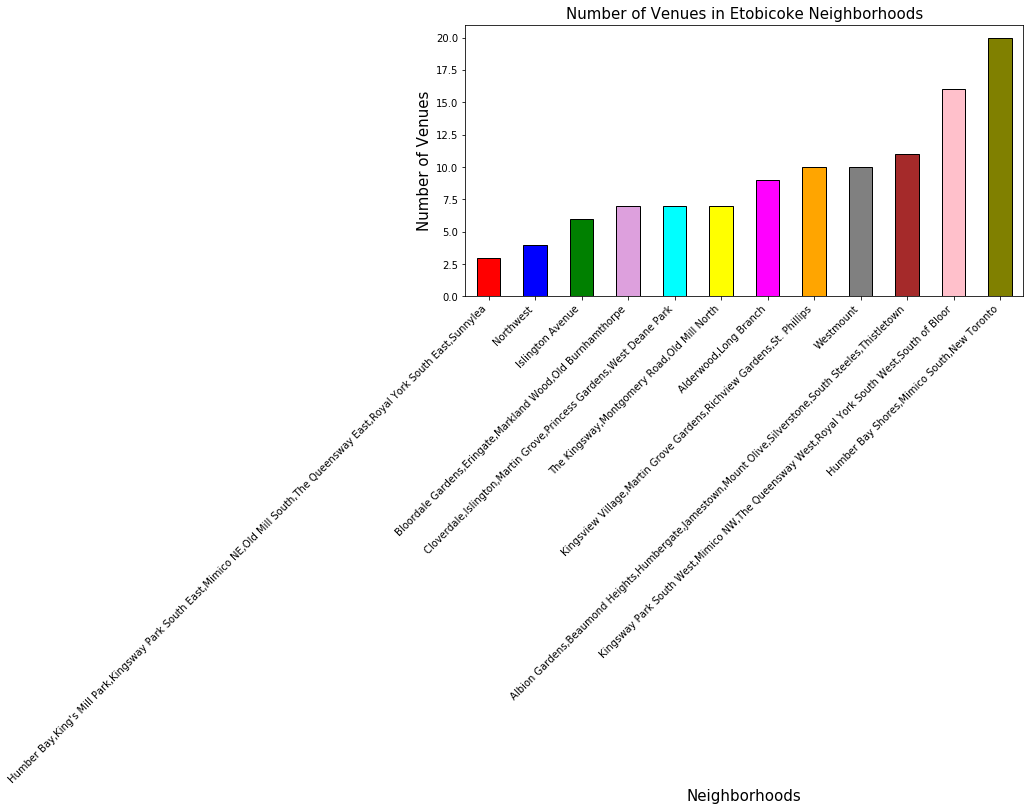

In [18]:
# For a better visualization, lets plot the above dataset into a bar graph to see how the venues are distributed among the neighborhoods.
colors= [('red','blue','green','plum','cyan','yellow','magenta','orange','gray','brown','pink','olive')] 

label= ['Neighborhood']
etobicoke_totalvenues.plot(kind='bar', color=colors, figsize=(10, 5), legend=None, edgecolor='black')
plt.xlabel('Neighborhoods', fontsize=15)
plt.ylabel('Number of Venues', fontsize=15)
plt.xticks(fontsize=10, rotation = 45, ha="right")
plt.title('Number of Venues in Etobicoke Neighborhoods',fontsize=15)
plt.show()
    


Among the neighborhood venues which ones are pizza places? Which neighborhoods have 1 or more venue category labeled as pizza place?

In [19]:
etobicoke_pizza=etobicoke_venues[etobicoke_venues['Venue Category'].str.contains('Pizza')]
etobicoke_pizza

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
8,"Cloverdale,Islington,Martin Grove,Princess Gar...",43.650943,-79.554724,Pizza Pizza,Pizza Place
9,"Cloverdale,Islington,Martin Grove,Princess Gar...",43.650943,-79.554724,Pizza Nova,Pizza Place
16,"Bloordale Gardens,Eringate,Markland Wood,Old B...",43.643515,-79.577201,Pizza Hut,Pizza Place
22,Westmount,43.696319,-79.532242,Pizza Hut,Pizza Place
25,Westmount,43.696319,-79.532242,Pizza Nova,Pizza Place
35,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724,Pizza Pizza,Pizza Place
43,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,Domino's Pizza,Pizza Place
65,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437,Pizza Pizza,Pizza Place
71,"Alderwood,Long Branch",43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,Pizza Place
76,"Alderwood,Long Branch",43.602414,-79.543484,Pizza Pizza,Pizza Place


In [20]:
print('{} pizza place venues were returned by Foursquare.'.format(etobicoke_pizza.shape[0]))

10 pizza place venues were returned by Foursquare.


A total of 7 Etobicoke neighborhoods have 10 pizza places between them. The exact venues are listed below.

In [21]:
etobicoke_pizza.Venue

8                          Pizza Pizza
9                           Pizza Nova
16                           Pizza Hut
22                           Pizza Hut
25                          Pizza Nova
35                         Pizza Pizza
43                      Domino's Pizza
65                         Pizza Pizza
71    Il Paesano Pizzeria & Restaurant
76                         Pizza Pizza
Name: Venue, dtype: object

Using folium map will visualize the Etobicoke neighborhoods and superimpose them markers showing the pizza place venues. 

In [22]:
map_etobicoke = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(etobicoke['Latitude'], etobicoke['Longitude'], etobicoke['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_etobicoke)  
    
# add the Pizza PLace veues as red circle markers
for lat, lng, label in zip(etobicoke_pizza['Neighborhood Latitude'], etobicoke_pizza['Neighborhood Longitude'], etobicoke_pizza['Venue Category']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(map_etobicoke)

# display map
map_etobicoke

Note there are 10 pizza places but the above map displays only 7 red markers on the map since 3 neighborhoods in Etobicoke has 2 pizza places each as shown in the dataset below.

In [23]:
etobicoke_totalpizza=etobicoke_pizza.groupby('Neighborhood').count().sort_values(['Venue'])
etobicoke_totalpizza.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category'], axis=1, inplace=True)
etobicoke_totalpizza

,Venue
Neighborhood,
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",1
"Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe",1
"Humber Bay Shores,Mimico South,New Toronto",1
"Kingsview Village,Martin Grove Gardens,Richview Gardens,St. Phillips",1
"Alderwood,Long Branch",2
"Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park",2
Westmount,2


From the map above, we can see the the distribution of pizza places among the Etobicoke neighborhoods. It is clear there are 5 neighborhoods with no venues categorized as pizza places. Lets create a new dataframe with only the neighborhoods that do not have a pizza place.

In [24]:
etobicoke_nopizza=etobicoke_venues.set_index("Neighborhood")
etobicoke_nopizza.drop(["Alderwood,Long Branch", "Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",
                                           "Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe","Westmount",
                                          "Kingsview Village,Martin Grove Gardens,Richview Gardens,St. Phillips",
                                          "Humber Bay Shores,Mimico South,New Toronto","Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park"], axis=0, inplace=True) 
etobicoke_nopizza=etobicoke_nopizza.reset_index()
etobicoke_nopizza.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Islington Avenue,43.667856,-79.532242,Java Joe's Village Cafe,Café
1,Islington Avenue,43.667856,-79.532242,TD Canada Trust,Bank
2,Islington Avenue,43.667856,-79.532242,Shoppers Drug Mart,Pharmacy
3,Islington Avenue,43.667856,-79.532242,Foodland,Grocery Store
4,Islington Avenue,43.667856,-79.532242,Thorncrest Drug Store,Pharmacy


#### Analyze Each Neighborhood

Based on our analysis above, there are 5 Etobicoke neighborhoods that do not have a pizza place. I will start by one-hot encoding the Venue Categories. Then will use this output sequence data to determine the the most common venues in the neighborhoods. 

In [25]:
# one hot encoding
etobicoke_onehot = pd.get_dummies(etobicoke_nopizza[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
etobicoke_onehot['Neighborhood'] = etobicoke_nopizza['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [etobicoke_onehot.columns[-1]] + list(etobicoke_onehot.columns[:-1])
etobicoke_onehot = etobicoke_onehot[fixed_columns]

etobicoke_onehot.head()

,Neighborhood,Bakery,Bank,Bar,Baseball Field,Burger Joint,Burrito Place,Café,Coffee Shop,Convenience Store,Discount Store,Drugstore,Fast Food Restaurant,Flower Shop,Furniture / Home Store,Grocery Store,Gym,Liquor Store,Locksmith,Park,Pharmacy,Pub,Rental Car Location,River,Sandwich Place,Shopping Mall,Smoke Shop,Social Club,Supplement Shop,Tanning Salon,Thrift / Vintage Store,Wings Joint
0,Islington Avenue,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Islington Avenue,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Islington Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Islington Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Islington Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# size of the new dataframe size.
etobicoke_onehot.shape

(36, 32)

In [27]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
etobicoke_grouped = etobicoke_onehot.groupby('Neighborhood').mean().reset_index()
etobicoke_grouped

,Neighborhood,Bakery,Bank,Bar,Baseball Field,Burger Joint,Burrito Place,Café,Coffee Shop,Convenience Store,Discount Store,Drugstore,Fast Food Restaurant,Flower Shop,Furniture / Home Store,Grocery Store,Gym,Liquor Store,Locksmith,Park,Pharmacy,Pub,Rental Car Location,River,Sandwich Place,Shopping Mall,Smoke Shop,Social Club,Supplement Shop,Tanning Salon,Thrift / Vintage Store,Wings Joint
0,"Humber Bay,King's Mill Park,Kingsway Park Sout...",0.0000,0.000000,0.000000,0.333333,0.0000,0.0000,0.000000,0.000000,0.0000,0.0000,0.00,0.0000,0.0000,0.00,0.000000,0.0000,0.000000,0.333333,0.333333,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
1,Islington Avenue,0.0000,0.166667,0.000000,0.000000,0.0000,0.0000,0.166667,0.000000,0.0000,0.0000,0.00,0.0000,0.0000,0.00,0.166667,0.0000,0.000000,0.000000,0.000000,0.333333,0.000000,0.00,0.000000,0.0000,0.166667,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
2,"Kingsway Park South West,Mimico NW,The Queensw...",0.0625,0.062500,0.000000,0.000000,0.0625,0.0625,0.000000,0.000000,0.0625,0.0625,0.00,0.0625,0.0625,0.00,0.062500,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0625,0.000000,0.000000,0.0625,0.0625,0.0625,0.0625,0.0625
3,Northwest,0.0000,0.000000,0.250000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0000,0.0000,0.25,0.0000,0.0000,0.25,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
4,"The Kingsway,Montgomery Road,Old Mill North",0.0000,0.000000,0.142857,0.000000,0.0000,0.0000,0.000000,0.142857,0.0000,0.0000,0.00,0.0000,0.0000,0.00,0.000000,0.0000,0.142857,0.000000,0.142857,0.000000,0.142857,0.00,0.142857,0.0000,0.000000,0.142857,0.0000,0.0000,0.0000,0.0000,0.0000


In [28]:
#confirm the new size
etobicoke_grouped.shape

(5, 32)

In [29]:
# print each neighborhood along with the top 3 most common venues

num_top_venues = 3

for hood in etobicoke_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = etobicoke_grouped[etobicoke_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea----
            venue  freq
0  Baseball Field  0.33
1            Park  0.33
2       Locksmith  0.33


----Islington Avenue----
           venue  freq
0       Pharmacy  0.33
1  Shopping Mall  0.17
2           Bank  0.17


----Kingsway Park South West,Mimico NW,The Queensway West,Royal York South West,South of Bloor----
                    venue  freq
0                  Bakery  0.06
1    Fast Food Restaurant  0.06
2  Thrift / Vintage Store  0.06


----Northwest----
                    venue  freq
0                     Bar  0.25
1  Furniture / Home Store  0.25
2     Rental Car Location  0.25


----The Kingsway,Montgomery Road,Old Mill North----
         venue  freq
0   Smoke Shop  0.14
1  Coffee Shop  0.14
2         Park  0.14




In [30]:
# Put the above data into a pandas dataframe. First write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Create the new dataframe and display the top 5 venues for each neighborhood.

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = etobicoke_grouped['Neighborhood']

for ind in np.arange(etobicoke_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(etobicoke_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Humber Bay,King's Mill Park,Kingsway Park Sout...",Baseball Field,Park,Locksmith,Wings Joint,Furniture / Home Store
1,Islington Avenue,Pharmacy,Café,Shopping Mall,Grocery Store,Bank
2,"Kingsway Park South West,Mimico NW,The Queensw...",Wings Joint,Thrift / Vintage Store,Bank,Burger Joint,Burrito Place
3,Northwest,Bar,Rental Car Location,Drugstore,Furniture / Home Store,Wings Joint
4,"The Kingsway,Montgomery Road,Old Mill North",Coffee Shop,Bar,Smoke Shop,Liquor Store,River


#### Cluster Neighborhoods

To examine the 5 Etobicoke neighborhoods without a pizza place, I will attempt to cluster the venues of these locations using K-means. I will first run the elbow method to find the optimum k-means value.

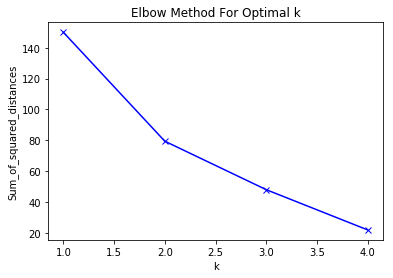

In [31]:
from sklearn.preprocessing import StandardScaler

#To use the categorical features, we need to convert the categorical features to binary using pandas get dummies as I did earlier using one=hot encoding.
#To give equal importance to all features, we need to scale the continuous features. I will be using StandardScaler.

etobicoke_grouped_clustering = etobicoke_grouped.drop('Neighborhood', 1)

X = etobicoke_grouped_clustering.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

#For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

Sum_of_squared_distances = []
K = range(1,5)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_dataset)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

I will run K-Means to cluster the neighborhoods into 2 clusters because when analysis the K-Means with elbow method displays 2 as the optimum k of the K-Means.

In [32]:
# set number of clusters
kclusters = 2

etobicoke_grouped_clustering = etobicoke_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(etobicoke_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 1], dtype=int32)

Below you will find a table with cluster labels for each neighborhood as well as the top 5 most common venues for each neighborhood.

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

etobicoke_merged = etobicoke_nopizza

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
etobicoke_merged = etobicoke_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
etobicoke_merged.drop(['Venue', 'Venue Category'], axis=1, inplace=True)

etobicoke_merged.drop_duplicates(subset=None, keep="first", inplace=True)
etobicoke_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Islington Avenue,43.667856,-79.532242,1,Pharmacy,Café,Shopping Mall,Grocery Store,Bank
6,Northwest,43.706748,-79.594054,1,Bar,Rental Car Location,Drugstore,Furniture / Home Store,Wings Joint
10,"The Kingsway,Montgomery Road,Old Mill North",43.653654,-79.506944,1,Coffee Shop,Bar,Smoke Shop,Liquor Store,River
17,"Humber Bay,King's Mill Park,Kingsway Park Sout...",43.636258,-79.498509,0,Baseball Field,Park,Locksmith,Wings Joint,Furniture / Home Store
20,"Kingsway Park South West,Mimico NW,The Queensw...",43.628841,-79.520999,1,Wings Joint,Thrift / Vintage Store,Bank,Burger Joint,Burrito Place


As we can see from the table above, 4 out of the 5 neighborhoods were clustered into 1 cluster. Lets visualize the the resulting clusters.

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(etobicoke_merged['Neighborhood Latitude'], etobicoke_merged['Neighborhood Longitude'], etobicoke_merged['Neighborhood'], etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine Clusters

Now we can examine the 2 clusters and determine what distinguishes each cluster. Four out the 5 neighborhood groups clustered into 1 have some type of eatery as one of their 3 most common venues. The lone neighborhood clustered alone does not include an eatery as one of the 3 most common venues. As shown below:

In [35]:
newpizza_neighborhood= etobicoke_merged[etobicoke_merged['Neighborhood'].str.contains('Humber')]
newpizza_neighborhood.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,"Humber Bay,King's Mill Park,Kingsway Park Sout...",43.636258,-79.498509,0,Baseball Field,Park,Locksmith,Wings Joint,Furniture / Home Store


Based on the clustering data we estimate that the neighborhood group of "Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea" would be the ideal new Etobcicoke location for a new pizza place. To confirm using folium map lets visualize the potential new pizza place among the other pizza places in Etobicoke neighborhoods. 

We will map and label the current pizza places in red circles, the neighborhoods without any pizza place in blue circles and the potential new pizza place in a green/yellow circle.

In [36]:
map_etobicoke = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add markers to map
for lat, lng, label in zip(etobicoke['Latitude'], etobicoke['Longitude'], etobicoke['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_etobicoke)  
    
# add the Pizza PLace veues as red circle markers
for lat, lng, label in zip(etobicoke_pizza['Neighborhood Latitude'], etobicoke_pizza['Neighborhood Longitude'], etobicoke_pizza['Venue Category']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(map_etobicoke)

# add a green circle marker to represent the potenital new Pizza PLace
for lat, lng in zip(newpizza_neighborhood['Neighborhood Latitude'], newpizza_neighborhood['Neighborhood Longitude']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.7
    ).add_to(map_etobicoke)


# display map
map_etobicoke

This concludes our analysis. Out of 12 grouped neighborhoods in Etobicoke, I was able to narrow it down to 5 neighborhoods that do not have a pizza place. Using clustering analysis, we saw that only 1 neighborhood out of the 5 neighborhoods does not contain an eatery in the top 3 most common venues. This makes the neighborhood ideal location for a new pizza place.

In [37]:
print(neighborhoods_venues_sorted.loc[0])

Cluster Labels                                                           0
Neighborhood             Humber Bay,King's Mill Park,Kingsway Park Sout...
1st Most Common Venue                                       Baseball Field
2nd Most Common Venue                                                 Park
3rd Most Common Venue                                            Locksmith
4th Most Common Venue                                          Wings Joint
5th Most Common Venue                               Furniture / Home Store
Name: 0, dtype: object


## Results and Discussion <a name="results"></a>

Our analysis using Foursquare API shows the borough of Etobicoke has a total of 110 venues. out of these 110 venues 84 are unique venues and 56 are unique venue categories among its 12 grouped neighborhoods. Out of theses 12 neighborhoods, 7 of them have 10 pizza places among them. The following neighborhoods have 2 pizza places each:
    - Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park
    - Westmount
    - Alderwood,Long Branch
That leaves 5 neighborhoods with no venue categories labeled as pizza places. 

Out of 12 neighborhoods we narrowed our search to 5 neighborhoods. To further narrow our search, we clustered our neighborhoods using K-Means. The 5 neighborhoods were clustered into 2 distinct groups. The group labeled as cluster 1 included the following Etobicoke neighborhoods:
    - Islington Avenue
    - Kingsway Park South West,Mimico NW,The Queensway West,Royal York South
    - NorthWest
    - The Kingsway,Montgomery Road,Old Mill North

Analyzing the types of venue in the 5 neighborhoods reveals interesting insight.  All of the above neighborhoods that were clustered into one group have a common trait of an eatery such as a cafe, bar, Coffee Shop, Wing's Joint as common 3 top venues. The 5th neighborhood was clustered alone in a group: Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea. The top 3 most common venue in this grouped neighborhood is a baseball field, park and locksmith business.

This suggests to potential entrepreneurs/ chefs people that the neighborhood group of "Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea" would be an ideal location in Etobicoke to open a new pizza place as there are no other eateries in the immediate are to offer immediate direct competition. The type of venues in the area such as a baseball field and park are venues that create high foot traffic area and offer more opportunity for customers to visit the new pizza place.

The other 4 neighborhoods without a pizza place could potentially be new sites for a pizza place. But further analysis is needed to asses the level of competition from other eateries in the neighborhood, prior to making recommendation to interested business restaurateurs.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the best neighborhood in Etobicoke to open a pizza place for potential entrepreneurs or chefs interested in opening a restaurant. Etobicoke has many venues but only handful of pizza places. Only 10 pizza places to be exact. An ideal neighborhood has zero to minimal competition from other eateries and surrounding venues should offer high foot traffic. Based on my analysis, the neighborhood group of "Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea" would be an ideal location in Etobicoke to open a new pizza place based on the aforementioned criteria. This would be my recommendation to potential entrepreneurs or chefs.